In [152]:
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import pandas as pd

df = pd.read_csv('CryptoTableauData.csv')
df.head(10)
df_bitcoin = df[df['crypto_name'] == 'Bitcoin']
df_bitcoin.head()

df_ret = pd.read_csv('CryptoReturnsData.csv')
df_ret = df_ret.drop(['trade_date'], axis=1)
df_ret = df_ret.dropna()
df_ret_abs = df_ret.abs()
df_ret.head()

df_logret = pd.read_csv('CryptoLogReturnsData.csv')
df_logret = df_logret.drop(['trade_date'], axis=1)
df_logret = df_logret.dropna()
df_logret_abs = df_logret.abs()
df_logret.head()

df_vol = pd.read_csv('CryptoVolumeData.csv')
df_vol = df_vol.drop(['trade_date'], axis=1)
df_vol = df_vol.dropna()
#df_vol = df_vol.abs()
df_vol.head()

,Binance_Coin,Bitcoin,Bitcoin_Cash,Bitcoin_SV,Cardano,Chainlink,Crypto_com_Coin,EOS,Ethereum,Huobi_Token,Litecoin,Monero,NEO,Stellar,Tether,Tezos,TRON,UNUS_SED_LEO,USD_Coin,XRP
0,13595933.0,2285901.0,8260875.0,4913763.0,1.109614e+09,32612915,393131898,554819091.0,43968425.0,27610043.0,57244277.0,3110149.0,49121561.0,4.091794e+09,23973071925,11407697.0,4.278287e+10,6863967,222754025,4.959182e+09
1,12725873.0,2277170.0,8908406.0,4778668.0,9.123387e+08,39574860,383223801,528716218.0,47823167.0,27839594.0,55616064.0,4016523.0,41989830.0,4.423396e+09,24597499287,13197268.0,4.307836e+10,7477121,208342328,4.702822e+09
2,14481198.0,2806769.0,8478598.0,5295787.0,1.458810e+09,45666041,624589389,779468280.0,57224534.0,29730444.0,69298745.0,3247277.0,47475221.0,4.775886e+09,30710349697,18755269.0,4.902068e+10,9116221,310602968,5.573760e+09
3,12719992.0,2793752.0,7750431.0,5026660.0,1.892762e+09,44377600,597677920,876575966.0,53368351.0,29452557.0,75693466.0,4651344.0,45056169.0,9.623521e+09,30721581637,14756402.0,4.501190e+10,12641495,294667615,6.534276e+09
4,11626864.0,2473762.0,8063560.0,4282231.0,1.607080e+09,56364011,617465025,669064411.0,53330141.0,41762497.0,58873479.0,4072668.0,41137525.0,4.384331e+09,28578448466,26804412.0,4.993091e+10,13814759,254889570,5.857837e+09


In [153]:
def adfuller_test(series, signif=0.05):
    x = adfuller(series, autolag='AIC')

    #using dictionary saves different data types (float, int, boolean)
    output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }

    for key, val in x[4].items():
         output[f'Critical value {key}'] = val
    
    return pd.Series(output)

In [154]:
df_logret_adf = df_logret_abs.apply(lambda x: adfuller_test(np.array(x)), axis=0)
df_vol_adf = df_vol.apply(lambda x: adfuller_test(np.array(x)), axis=0)
df_logret_adf.head()
#df_vol_adf.head()

,Binance_Coin,Bitcoin,Bitcoin_Cash,Bitcoin_SV,Cardano,Chainlink,Crypto_com_Coin,EOS,Ethereum,Huobi_Token,Litecoin,Monero,NEO,Stellar,Tether,Tezos,TRON,UNUS_SED_LEO,USD_Coin,XRP
Test Statistic,-4.495731,-4.035716,-4.942127,-5.718945,-16.572584,-16.059405,-3.286203,-7.046448,-5.312662,-6.76409,-6.719079,-4.07046,-3.888246,-15.821224,-6.757029,-7.267776,-6.577143,-7.775443,-2.244799,-5.474674
P-value,0.0002,0.001235,0.000029,0.000001,0.0,0.0,0.015507,0.0,0.000005,0.0,0.0,0.001083,0.002123,0.0,0.0,0.0,0.0,0.0,0.190389,0.000002
Number of lags,6,10,6,3,0,0,16,3,7,3,3,9,9,0,3,3,3,2,15,7
Number of observations,344,340,344,347,350,350,334,347,343,347,347,341,341,350,347,347,347,348,335,343
Reject (signif. level 0.05),True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True


In [155]:
import warnings
warnings.filterwarnings('ignore')

def archmodel(series):
    garch11 = arch_model(series, p=1, q=1)
    res = garch11.fit(update_freq=10)
    return pd.Series(res.params)

df_ret_garch = df_ret.apply(lambda x: archmodel(np.array(x)), axis=0)
df_vol_garch = df_vol.apply(lambda x: archmodel(np.array(x)), axis=0)
df_ret_garch.head()
#df_vol_garch.head()

Iteration:     10,   Func. Count:     59,   Neg. LLF: 999.7108790101602
Optimization terminated successfully    (Exit mode 0)
            Current function value: 999.7108790101602
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     57,   Neg. LLF: 923.5446604239692
Optimization terminated successfully    (Exit mode 0)
            Current function value: 923.5446605615932
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1043.2177241297209
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1164.6427500722675
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9
Iteration:     10,   F

C:\Users\Tharun\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



            Current function value: 5953.468562800728
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5416.072451047798
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5911.472415599237
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5759.2510556812695
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7908.557174069838
            Iterations: 5
            Function evaluations: 27
            Gradient evaluations: 5
Optimization term

,Binance_Coin,Bitcoin,Bitcoin_Cash,Bitcoin_SV,Cardano,Chainlink,Crypto_com_Coin,EOS,Ethereum,Huobi_Token,Litecoin,Monero,NEO,Stellar,Tether,Tezos,TRON,UNUS_SED_LEO,USD_Coin,XRP
mu,0.210851,0.273054,0.034143,-0.161004,0.497689,0.666351,0.549151,-0.096870,0.375206,0.169179,0.152438,0.379062,0.442930,0.131334,0.048800,0.362425,0.252735,0.067124,-0.001062,0.016300
omega,0.931068,0.766258,0.795081,4.118419,4.750346,1.259459,1.148955,0.563681,0.768632,0.801314,1.311303,0.711316,2.068518,3.651085,0.025647,1.130707,1.100177,0.558186,0.000003,1.484955
alpha[1],0.203475,0.207603,0.155344,0.271799,0.129684,0.083554,0.073048,0.138946,0.115826,0.211686,0.147127,0.116225,0.110080,0.120715,0.358763,0.096316,0.197799,0.227565,0.123945,0.187855
beta[1],0.787854,0.792397,0.844656,0.728201,0.717564,0.897439,0.872993,0.861054,0.867676,0.788314,0.808816,0.864393,0.821105,0.708991,0.641237,0.879206,0.795744,0.568023,0.876470,0.741546


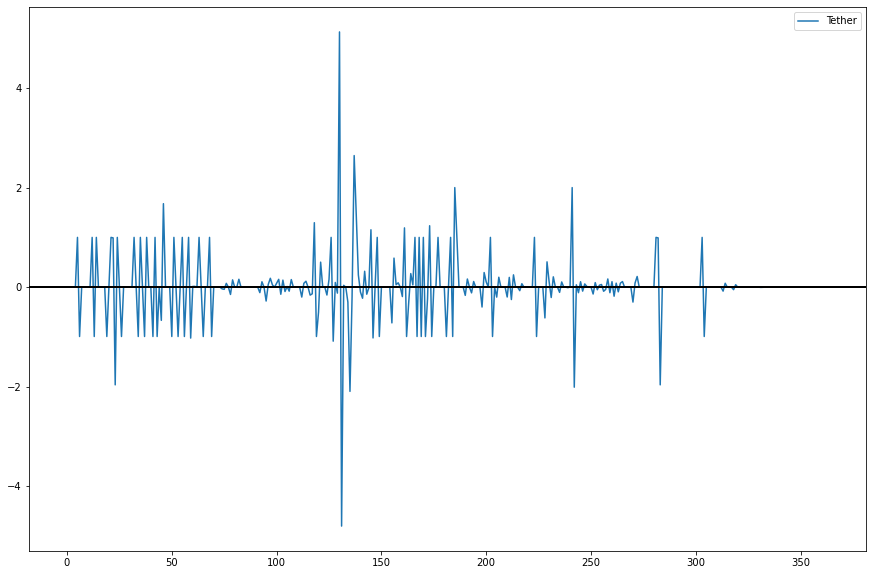

In [177]:
df_ret[['Tether']].plot(figsize=(15, 10)).axhline(color='black', linewidth=2)

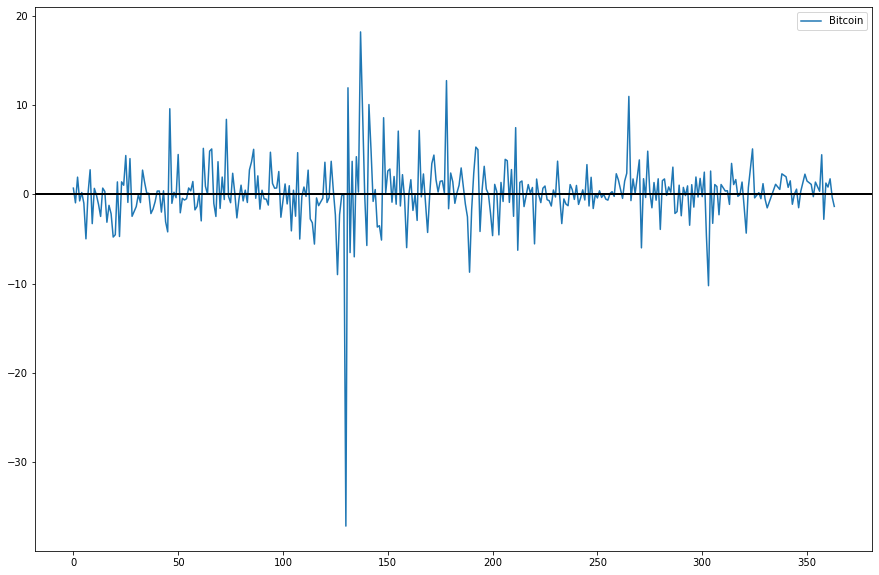

In [178]:
df_ret[['Bitcoin']].plot(figsize=(15, 10)).axhline(color='black', linewidth=2)

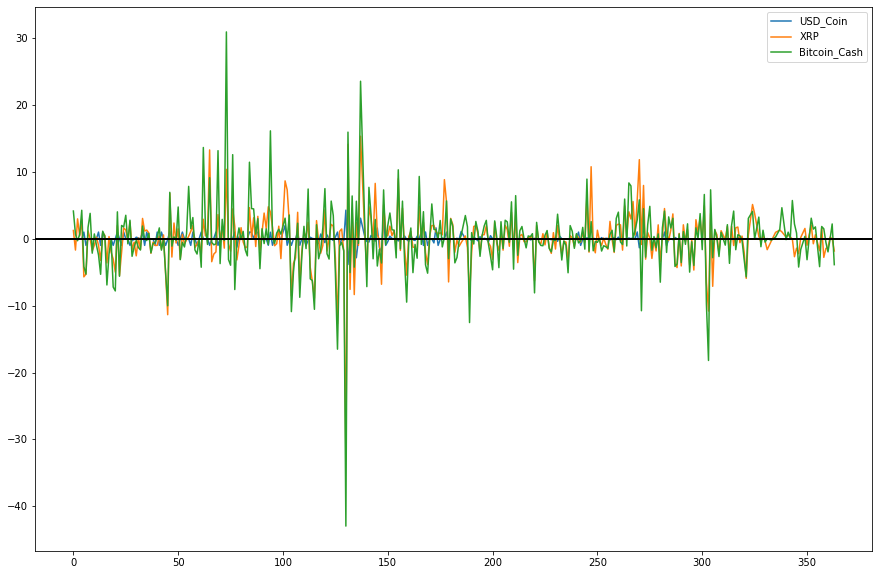

In [179]:
df_ret[['USD_Coin','XRP','Bitcoin_Cash']].plot(figsize=(15, 10)).axhline(color='black', linewidth=2)

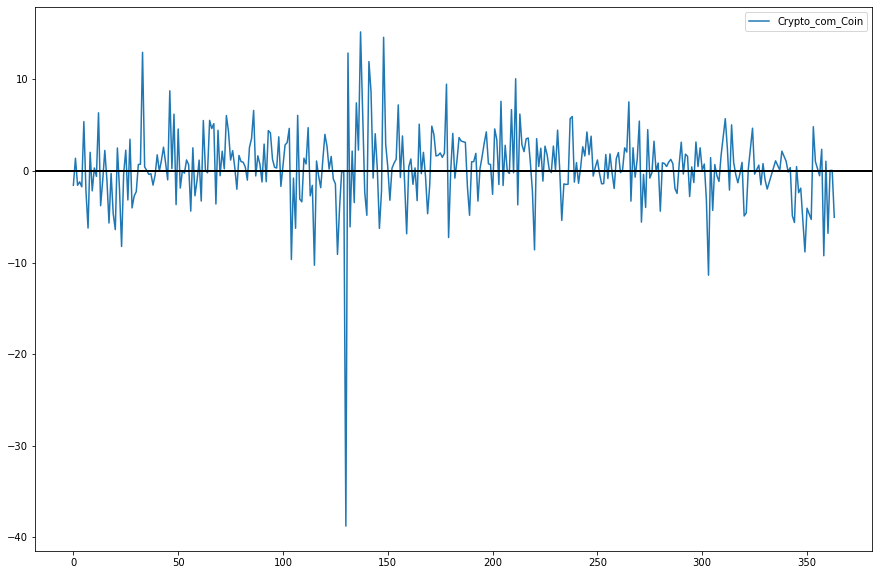

In [180]:
df_ret[['Crypto_com_Coin']].plot(figsize=(15, 10)).axhline(color='black', linewidth=2)

In [182]:
df_ret_garch[['Bitcoin','Tether']]

,Bitcoin,Tether
mu,0.273054,0.048800
omega,0.766258,0.025647
alpha[1],0.207603,0.358763
beta[1],0.792397,0.641237


In [181]:
import warnings
warnings.filterwarnings('ignore')

def archmodel(series):
    tarch11 = arch_model(series, p=1, q=1, power=1.0)
    res = tarch11.fit(update_freq=10)
    return pd.Series(res.params)

df_ret_tarch = df_ret.apply(lambda x: archmodel(np.array(x)), axis=0)
df_vol_tarch = df_vol.apply(lambda x: archmodel(np.array(x)), axis=0)
df_ret_tarch.head()
#df_vol_tarch.head()

Iteration:     10,   Func. Count:     59,   Neg. LLF: 1005.8742811052673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1005.8742817686705
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     61,   Neg. LLF: 927.2087592148193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 927.2087595335602
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1045.1261000735212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1045.1261000735212
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1176.2961550099863
Optimization terminated successfully    (Exit mode 0)
            Current functi

,Binance_Coin,Bitcoin,Bitcoin_Cash,Bitcoin_SV,Cardano,Chainlink,Crypto_com_Coin,EOS,Ethereum,Huobi_Token,Litecoin,Monero,NEO,Stellar,Tether,Tezos,TRON,UNUS_SED_LEO,USD_Coin,XRP
mu,0.297901,0.429464,0.321970,-0.275000,0.515367,0.771133,0.592405,1.214248e-08,0.387654,0.057706,0.335173,0.583648,0.327276,0.054933,0.042645,0.355011,0.105797,0.055737,0.000001,-0.038575
omega,0.216299,0.172379,0.190067,0.799705,0.670356,0.178395,0.175595,1.618820e-01,0.149276,0.185520,0.162485,0.112782,0.282858,1.013427,0.066511,0.192569,0.208101,0.374826,0.024543,0.124569
alpha[1],0.157946,0.124687,0.111290,0.251201,0.134378,0.088666,0.073881,9.836968e-02,0.094319,0.141631,0.114362,0.088257,0.096735,0.141253,0.284357,0.114127,0.132521,0.197157,0.145420,0.096223
beta[1],0.842054,0.875313,0.888710,0.748799,0.782539,0.911334,0.910901,9.016303e-01,0.905681,0.858369,0.885638,0.911743,0.876893,0.675934,0.715643,0.885873,0.867479,0.619149,0.854580,0.903777
